<a href="https://colab.research.google.com/github/mykhailodolitsoi/EDU_pytorch/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

Let's explore an example of PyTorch start-to-end workflow.

Resources:
- Notebook - https://www.learnpytorch.io/01_pytorch_workflow/

In [ ]:
what_we_are_covering = {
    1: "data: prepare and load",
    2: "build model",
    3: "fitting the model (training)",
    4: "making predictions and evaluating the model",
    5: "saving and loading the model",
    6: "put it all together"
}

In [ ]:
import torch
from torch import nn ## nn contains all of PyTorches building blocks for neural networks
import matplotlib.pyplot as plt
import numpy

## 1. Data (preparing and loading)

Data can be almost everything in machine learning.

* Excel speadsheet
* Images(video)
* Audio
* DNA
* Text

Machine learning is a game of 2 parts:
1. Get data in numerical representation.
2. Build a model to find and learn patterns in data.

To showcase this, let's create some *known* data using the linear regression formula.

We will use a linear regression formula to make a straight line with *known* **parameters**

In [ ]:
# create known parameters
weight = 0.7
bias = 0.3

# create the data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias
# X[:10], y[:10]
# X.shape, y.shape


### Splitting data into training and test sets(one of the most important concept in machine learning)

Let's create training and test sets with our data.

In [ ]:
# create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# len(X_train), len(X_test), len(y_train), len(y_test)

### Visualizitation the data

In [ ]:
# create a matplotlib function
def plot_predictions(train_data=X_train,
                     train_lables=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  # plot training data in blue
  plt.scatter(train_data, train_lables, c="b", s=4, label="Training data")

  # plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label = "Test data")

  # check if there are predictions
  if predictions is not None:
    # plot the predictions if not None
    plt.scatter(test_data, predictions, c="r", s=4, label = "Predictions")

  plt.legend(prop={"size": 14})
  plt.grid()



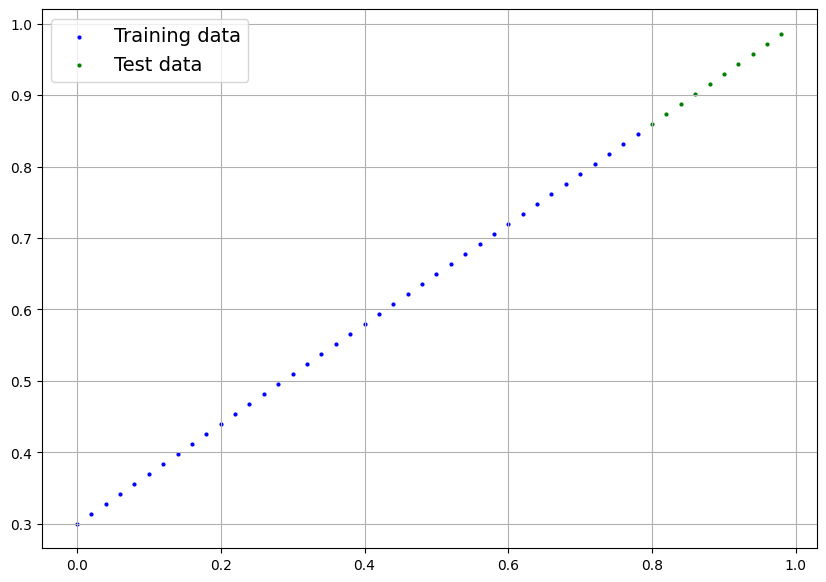

In [ ]:
plot_predictions()

## 2. Build a model

What our model does:
1. Start with random values(weight & bias).
2. Look at training data.
3. Adjust the random number to give a better representation of data.

We use two main algorithms:
1. Gradient descent
2. Backpropagation

In [ ]:
# create a linear regression model class
class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherhits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # forward method to define the computing in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias

### PyTorch model building essentials

* torch.nn - contains all of the building blocks for computational graphs (anothe definition of neural networks)
* torch.nn.Parameter - what parameter should our model learn, often a PyTorch layer from torch.nn will set these for us.
* torch.nn.Module - the base class for all neural network modules
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - all nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

CheatSheet - https://pytorch-cn.com/tutorials/beginner/ptcheat.html

### Checking the contents of our PyTorch model

We can check out our model parameters using `.parameters`

In [ ]:
# create a random seed
RANDOM_SEED = 0
torch.manual_seed(RANDOM_SEED)

# create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# check out the parameters
# list(model_0.parameters())

# list named pararmeters
model_0.state_dict()

OrderedDict([('weights', tensor([1.5410])), ('bias', tensor([-0.2934]))])

### Making predictions using `torch.inference_mode()`

To check out model's predictive power, let's see how well it predicts `y_test` based on `x_test.

When we pass the data through our model, it is going to run the data through the `forward()` method.

In [ ]:
# make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds, y_test

(tensor([[0.9394],
         [0.9702],
         [1.0010],
         [1.0318],
         [1.0626],
         [1.0935],
         [1.1243],
         [1.1551],
         [1.1859],
         [1.2167]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

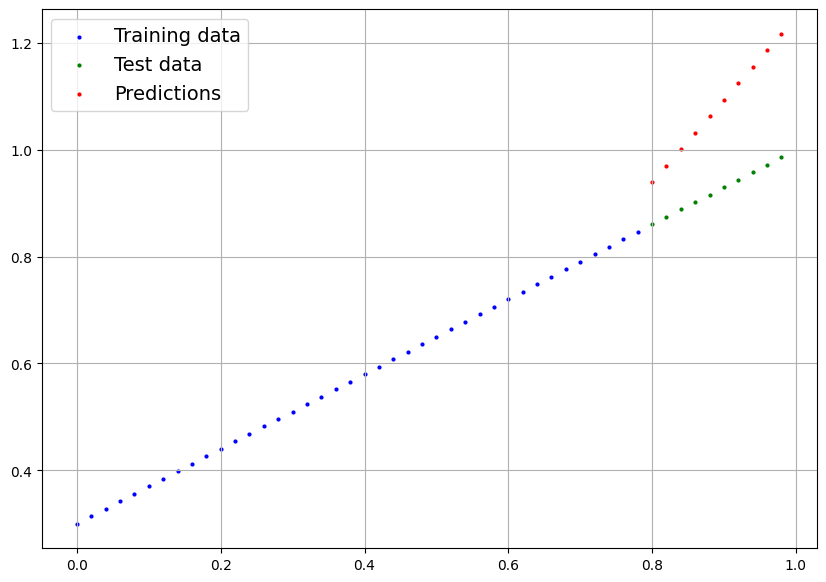

In [ ]:
# plot the predictions
plot_predictions(predictions=y_preds)

## 3. Train model

The idea of training is for a model to move from some **random** parameters to ideal ones.

Or in other words - from a poor representation of the data to a better one.

One way to measure how poor or how wrong your models prediction are is to use a `loss` function.

* Note: loss function may also be called a cost function or criterion in different fields/areas.

Things we need to train

* **Loss function:** a function to measure how wrong your models prediction are to ideal outputs, lower is better.
* **Optimizer:** takes into account the loss of a model and adjusts the models params(e.g. weight & bias) to improve loss function.

And specifically for PyTorch, we need:
* A training loop
* A test loop

In [ ]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # <- learning rate - possibly the most important hyperparameter you can set

### Building a training loop

A couple of things we need in training loop:

0. loop through the data.
1. forward pass - involves the data moving through our model's `forward()` function/s to make predictions on th data - also called forward propagation.
2. calculate the loss - compare forward pass predictions to ground truth labels.
3. optimize zero grad.
4. loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**).
5. optimize step - use the optimizer to adjust our model's params to improve the loss(**gradient descent**).

In [ ]:
# an epoch is 1 loop through the data (this is a hyperparameter because we have set it ourselves)
epochs = 600

# track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. loop through the data
for epoch in range(epochs):
    # set a moel to training mode
    model_0.train() # train mode in PyTorch set all parameters that require gradients to require gradients

    # 1. forward pass
    y_pred = model_0(X_train)

    #2. calculate a loss
    loss = loss_fn(y_pred, y_train)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. perform backpropagation on the loss with respect to parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval() # turns off gradient tracking
    with torch.inference_mode():
        # 1. do the forward pass
        test_pred = model_0(X_test)

        # 2. calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")


print(model_0.state_dict())
y_preds = test_pred

Epoch: 0 | Test: 0.27290406823158264 | Test loss: 0.16519367694854736
Epoch: 10 | Test: 0.22472169995307922 | Test loss: 0.2433406412601471
Epoch: 20 | Test: 0.201097771525383 | Test loss: 0.29282358288764954
Epoch: 30 | Test: 0.18786200881004333 | Test loss: 0.32511013746261597
Epoch: 40 | Test: 0.17970390617847443 | Test loss: 0.34498992562294006
Epoch: 50 | Test: 0.17393237352371216 | Test loss: 0.356270968914032
Epoch: 60 | Test: 0.16935725510120392 | Test loss: 0.36119240522384644
Epoch: 70 | Test: 0.165230393409729 | Test loss: 0.3639999330043793
Epoch: 80 | Test: 0.16156136989593506 | Test loss: 0.361240416765213
Epoch: 90 | Test: 0.15803322196006775 | Test loss: 0.3570892810821533
Epoch: 100 | Test: 0.15450511872768402 | Test loss: 0.35293811559677124
Epoch: 110 | Test: 0.1509770005941391 | Test loss: 0.34878700971603394
Epoch: 120 | Test: 0.14745983481407166 | Test loss: 0.3439490795135498
Epoch: 130 | Test: 0.14402107894420624 | Test loss: 0.33567696809768677
Epoch: 140 | Tes

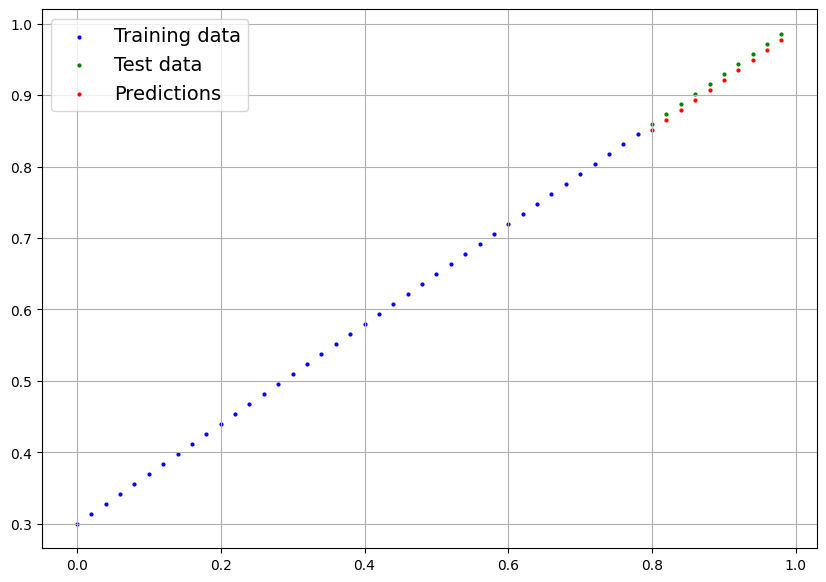

In [ ]:
# plot the predictions
plot_predictions(predictions=y_preds)

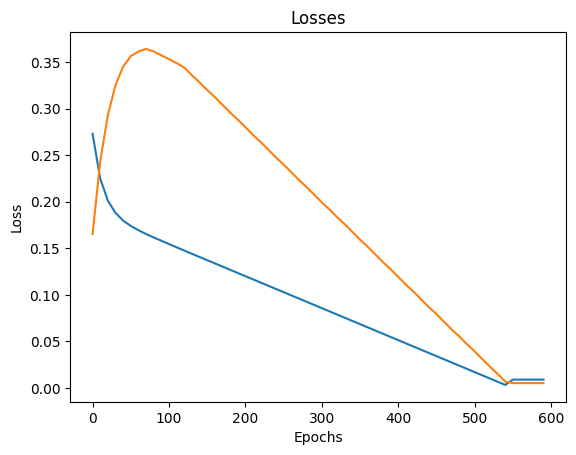

In [ ]:
plt.plot(epoch_count, torch.tensor(loss_values).cpu().numpy(), label = "Train loss")
plt.plot(epoch_count, torch.tensor(test_loss_values).cpu().numpy(), label = "Test loss")
plt.title("Losses")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

## 4. Saving a model

There are 3 main methods for saving and loading models in PyTorch

1. `torch.save` - allows you to save a PyTorch object in Python pickle format.
2. `torch.load` - allows ypu to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict` - this allows you to load model's saved state_dictionany

In [ ]:
# saving a PyTorch model
from pathlib import Path

MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create a model save path
MODEL_NAME = "01_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save a model state_dict
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

## 5. Loading a model

Since we saved our model's `state_dict` rather rhen entire model, we will create a new instanse of our model class and load the saved `state_dict()` into that.

In [ ]:
# to load in a saved state_dict we have to create a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# load the saved state dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

X = torch.arange(1, 2, 0.02).unsqueeze(dim = 1)
y = weight * X + bias

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# an epoch is 1 loop through the data (this is a hyperparameter because we have set it ourselves)
epochs = 600

# track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. loop through the data
for epoch in range(epochs):
    # set a moel to training mode
    loaded_model_0.train() # train mode in PyTorch set all parameters that require gradients to require gradients

    # 1. forward pass
    y_pred = loaded_model_0(X_train)

    #2. calculate a loss
    loss = loss_fn(y_pred, y_train)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. perform backpropagation on the loss with respect to parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()

    ### Testing
    loaded_model_0.eval() # turns off gradient tracking
    with torch.inference_mode():
        # 1. do the forward pass
        test_pred = loaded_model_0(X_test)

        # 2. calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")


print(loaded_model_0.state_dict())
y_preds = test_pred

Epoch: 0 | Test: 0.0076905726455152035 | Test loss: 0.007064866833388805
Epoch: 10 | Test: 0.0076905726455152035 | Test loss: 0.007064866833388805
Epoch: 20 | Test: 0.0076905726455152035 | Test loss: 0.007064866833388805
Epoch: 30 | Test: 0.0076905726455152035 | Test loss: 0.007064866833388805
Epoch: 40 | Test: 0.0076905726455152035 | Test loss: 0.007064866833388805
Epoch: 50 | Test: 0.0076905726455152035 | Test loss: 0.007064866833388805
Epoch: 60 | Test: 0.0076905726455152035 | Test loss: 0.007064866833388805
Epoch: 70 | Test: 0.0076905726455152035 | Test loss: 0.007064866833388805
Epoch: 80 | Test: 0.0076905726455152035 | Test loss: 0.007064866833388805
Epoch: 90 | Test: 0.0076905726455152035 | Test loss: 0.007064866833388805
Epoch: 100 | Test: 0.0076905726455152035 | Test loss: 0.007064866833388805
Epoch: 110 | Test: 0.0076905726455152035 | Test loss: 0.007064866833388805
Epoch: 120 | Test: 0.0076905726455152035 | Test loss: 0.007064866833388805
Epoch: 130 | Test: 0.007690572645515

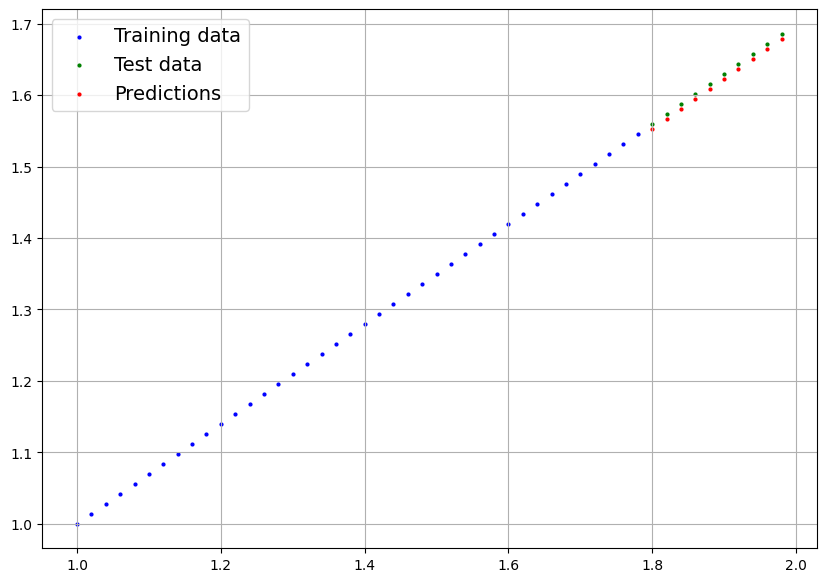

In [ ]:
# create a matplotlib function
def plot_predictions(train_data=X_train,
                     train_lables=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  # plot training data in blue
  plt.scatter(train_data, train_lables, c="b", s=4, label="Training data")

  # plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label = "Test data")

  # check if there are predictions
  if predictions is not None:
    # plot the predictions if not None
    plt.scatter(test_data, predictions, c="r", s=4, label = "Predictions")

  plt.legend(prop={"size": 14})
  plt.grid()

# plot the predictions
plot_predictions(predictions=y_preds)

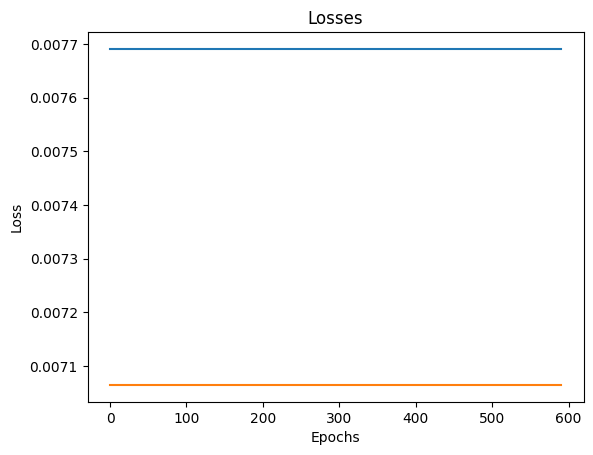

In [ ]:
plt.plot(epoch_count, torch.tensor(loss_values).cpu().numpy(), label = "Train loss")
plt.plot(epoch_count, torch.tensor(test_loss_values).cpu().numpy(), label = "Test loss")
plt.title("Losses")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()